# Image Checking of pMDI Spray Images

This program loads images from Photron SA-Z and performs a basic background correction

    @author Daniel Duke <daniel.duke@monash.edu>
    @copyright (c) 2024 D.Duke
    @license GPL-3.0+
    @version 0.0.1
    @date 30/10/2025
    
    Multiphase Flow Laboratory
    Monash University, Australia


In [1]:
# core functions for image handling and plotting
from pySciCam.pySciCam import ImageSequence # https://github.com/djorlando24/pySciCam
import numpy as np
import glob, sys, os, copy
from tqdm.notebook import tqdm

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
#fig=plt.figure()
#x_ = np.linspace(0,10,100)
#plt.plot(x_,np.sin(x_));
#plt.title("Testing Matplotlib");

In [4]:
# image processing tools
import scipy.ndimage
#from skimage import feature

In [5]:
# Define where images come from.
source_images = "/Users/dduke/Desktop/S0004.mraw"

In [6]:
# Read in some background images. 
# Use the END of the image sequence due to pneumatic vibrations/settling.
B=ImageSequence(source_images, monochrome=False, width=896, height=920, rawtype='photron_mraw_mono_12bit',\
               frames=(5454,5554))

Reading /Users/dduke/Desktop/S0004.mraw
PFV 12-bit MRAW
File contains 5554 frames (896 x 920)
Reading frames 5454 to 5554
Read 117.0 MiB in 1.0 sec
	Data in memory:	 (100, 920, 896)
	Intensity range:	 0 to 4095 	 uint16
	Array size:	157.2 MB


In [7]:
# Read in some spray images
I=ImageSequence(source_images, monochrome=False, width=896, height=920, rawtype='photron_mraw_mono_12bit',\
               frames=(500,5550))

Reading /Users/dduke/Desktop/S0004.mraw
PFV 12-bit MRAW
File contains 5554 frames (896 x 920)
Reading frames 500 to 5550
Read 5954.0 MiB in 48.1 sec
	Data in memory:	 (5050, 920, 896)
	Intensity range:	 0 to 4095 	 uint16
	Array size:	7939.9 MB


## Background Corrections

In [8]:
# Time-average background
Bavg_mono = np.mean(B.arr,axis=0)

# Boost the minimum level to avoid division by zero later.
# The number chosen for the mask here is arbitrary.
# I let it be 1% of the max intensity.
threshold=0.01*np.nanmax(Bavg_mono)
print("The raw counts for the threshold is: %i" % threshold)
Bavg_monoAdj = Bavg_mono[...]
Bavg_monoAdj[Bavg_monoAdj<threshold]=threshold
print("Background time-average min=%i, max=%i counts" % (Bavg_monoAdj.min(),Bavg_monoAdj.max()))

The raw counts for the threshold is: 40
Background time-average min=40, max=4095 counts


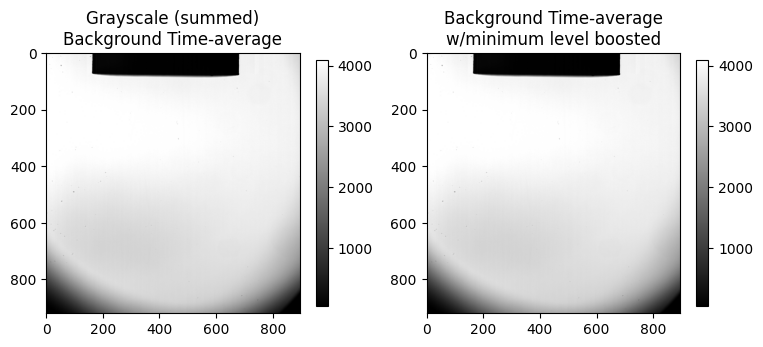

In [9]:
# Plot our progress.
fig=plt.figure(figsize=(9,4))
ax=fig.add_subplot(121)
ax.set_title("Grayscale (summed)\nBackground Time-average")
p=ax.imshow(Bavg_mono,cmap='grey')
plt.colorbar(p,shrink=.8)
ax=fig.add_subplot(122)
ax.set_title("Background Time-average\nw/minimum level boosted")
p=ax.imshow(Bavg_monoAdj,cmap='grey')
plt.colorbar(p,shrink=.8);

In [10]:
# Clear background raw images to save RAM.
del(B)

# Background Removal

In [29]:
# Determine usable time range for the spray images and only keep what we need.
spatiallyAveragedIntensity = np.nansum(np.nansum(I.arr, axis=-1),axis=-1)/np.prod(I.shape()[1:])
backgroundAveragedIntensity = np.nanmean(Bavg_mono)

(0, 4950)


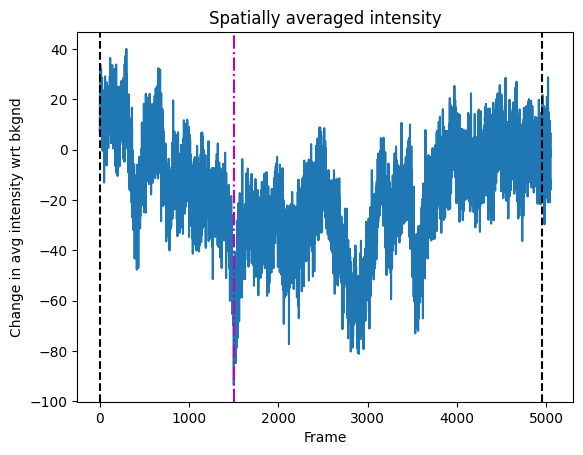

In [34]:
# Minimum intensty point for sampling
sampleFrameNum = np.where(spatiallyAveragedIntensity == np.nanmin(spatiallyAveragedIntensity))[0][0]

# plot
fig=plt.figure()
plt.plot(spatiallyAveragedIntensity-backgroundAveragedIntensity);
plt.title("Spatially averaged intensity"); plt.xlabel("Frame"); plt.ylabel("Change in avg intensity wrt bkgnd");

# Hard code it for now
t0=0
t1=I.shape()[0]-100
plt.axvline(t0,ls='--',c='k'); plt.axvline(t1,ls='--',c='k'); plt.axvline(sampleFrameNum,ls='-.',c='m');
print((t0,t1))

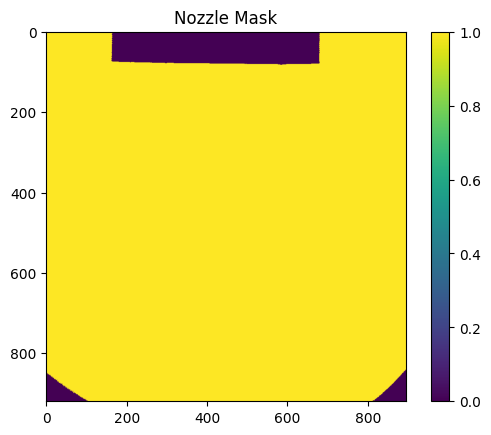

In [21]:
# CREATE MASK
# Mask the parts of the image blocked by the nozzle, where the spray image is below the threshold.
nozzle_mask = 1-(Bavg_monoAdj <= 10*threshold) # factor 10 is a guess.
#nozzle_mask = scipy.ndimage.binary_dilation(nozzle_mask,iterations=1) # grow the mask a few px

fig=plt.figure()
plt.imshow(nozzle_mask);
plt.title("Nozzle Mask");
plt.colorbar();

In [22]:
# Make arrays to store result in 
Iproc = np.zeros(((t1-t0+1),I.shape()[1],I.shape()[2]))
Imean = np.zeros((I.shape()[1],I.shape()[2]))
Imean2 = np.zeros((I.shape()[1],I.shape()[2]))

# Remove the average background by division, and convert to extinction (dimensionless).
# Apply mask.
# Also make a time-average field while we are in the loop.

for i in tqdm(range(t0,t1)):
    Iproc[i-t0,...] = 1.0 - (I.arr[i,...] / Bavg_monoAdj) # background division
    Iproc[i-t0,...] = Iproc[i-t0,...] * nozzle_mask
    Imean += Iproc[i-t0,...] # keep sum for mean
    Imean2 += Iproc[i-t0,...]**2 # keep sum2 for later stdev

# Post calculate temporal statistics.
Imean  = Imean / float(t1-t0+1) # divide sum to get the mean.
Imean2 = Imean2/ float(t1-t0+1) # divide sum sq.
Istd = np.sqrt(Imean2 - Imean**2)

# Keep a sample raw frame for plotting in case I gets cleared.
Isample = I.arr[sampleFrameNum,...]

  0%|          | 0/4950 [00:00<?, ?it/s]

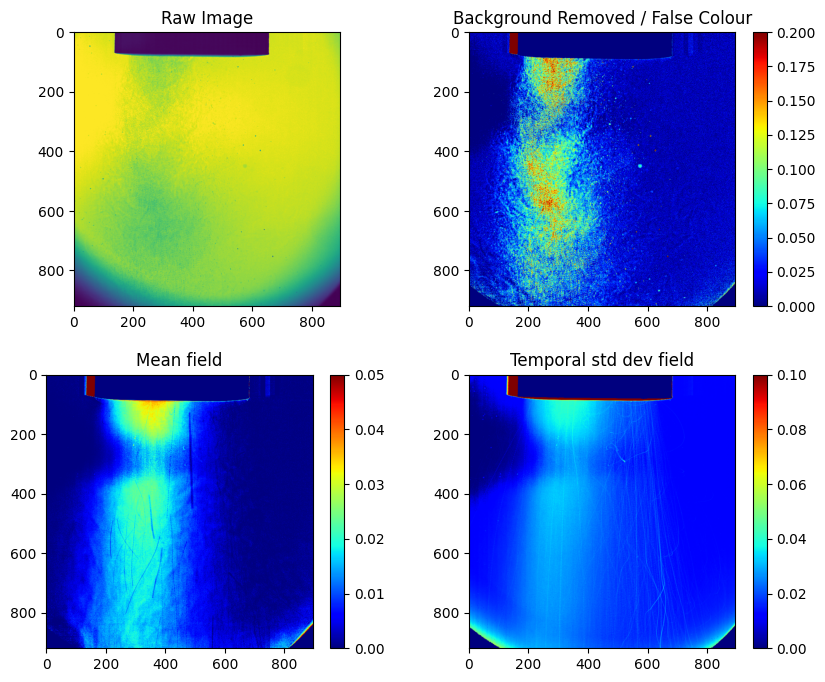

In [50]:
# Plot our progress
fig=plt.figure(figsize=(10,8))
ax=fig.add_subplot(221)
ax.set_title("Raw Image")
ax.imshow(Isample)

ax=fig.add_subplot(223)
p=ax.imshow(Imean,cmap='jet',vmin=0,vmax=0.05)
plt.colorbar(p);
plt.title("Mean field");

ax=fig.add_subplot(224)
p=ax.imshow(Istd,cmap='jet',vmin=0,vmax=0.10)
plt.colorbar(p);
plt.title("Temporal std dev field");

ax=fig.add_subplot(222)
ax.set_title("Background Removed / False Colour")
p=ax.imshow(Iproc[sampleFrameNum,...],cmap='jet',vmin=0,vmax=0.2)
plt.colorbar(p);
plt.subplots_adjust(hspace=0.25);

In [48]:
# Remove raw images to save RAM if we are satisfied with background removal.
del(I)